In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from icecream import ic

# local files
from src.embeddings.embeddings import get_embeddings
from src.util.data_handling.data_loader import save_as_pickle, load_dataset
from src.util.data_handling.string_generator import ALPHABETS
from src.data.edit_distance import edit_distance

INFO: Using numpy backend


# Save unlog transformed IHMP Data

In [3]:
def inverse_log_transformation(X):
    """When we generate X_raw, we add 1e-10 and take the log. Here we perform
    the inverse of these operations. However, instead of using 1e-10 we use 1e-11
    to ensure our numbers are all positive. If we subtracted 1e-10, then due to
    numerical stability issues, we'd end up with some negative values."""
    return np.exp(X) - 1e-11

In [4]:
data_name = 'ibd'
ihmp_data_path = '../data/interim/ihmp/{}_data.pickle'.format(data_name)
ihmp2_data_path = '../data/interim/ihmp2/{}_data.pickle'.format(data_name)

ihmp_data = load_dataset(ihmp_data_path)
ihmp_data = inverse_log_transformation(ihmp_data)
save_as_pickle(ihmp_data, ihmp2_data_path)

ihmp_data

,1000269,1008348,1009894,1012376,1017181,1017413,1019823,1019878,102222,1023075,...,964363,968675,968954,971907,975306,976470,979707,988375,988932,999046
sample id,,,,,,,,,,,,,,,,,,,,,
CSM5FZ3N,2.765363e-06,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,...,9.000000e-11,2.212227e-05,4.147918e-05,9.000000e-11,4.507395e-04,6.913182e-04,9.000000e-11,9.000000e-11,1.106118e-05,9.000000e-11
CSM5FZ3X,2.967731e-06,5.935372e-06,9.000000e-11,9.000000e-11,1.187065e-05,9.000000e-11,9.000000e-11,8.903013e-06,9.000000e-11,9.000000e-11,...,9.000000e-11,6.232055e-05,4.154706e-05,2.077358e-05,6.647516e-04,8.903013e-06,9.000000e-11,1.276086e-04,5.935372e-06,2.967731e-06
CSM5FZ3Z,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,1.211166e-05,9.000000e-11,1.211166e-05,9.000000e-11,9.000000e-11,...,9.000000e-11,6.055795e-05,4.037281e-06,9.000000e-11,2.099340e-04,9.000000e-11,9.000000e-11,9.000000e-11,2.018604e-05,9.000000e-11
CSM5FZ44,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,...,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11
CSM5FZ46,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,5.068411e-06,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,...,9.000000e-11,2.027337e-05,1.013673e-05,5.068411e-06,2.432795e-04,9.000000e-11,9.000000e-11,9.000000e-11,1.013673e-05,9.000000e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MSM5LLIO,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,1.663914e-05,4.754105e-06,9.000000e-11,...,9.000000e-11,3.090119e-05,1.426214e-05,9.508121e-06,1.297846e-03,9.508121e-06,9.000000e-11,1.416697e-03,4.754105e-06,9.000000e-11
MSM5LLIQ,1.619888e-04,9.000000e-11,9.000000e-11,9.000000e-11,1.921908e-05,1.098237e-05,9.000000e-11,6.232446e-04,9.000000e-11,9.000000e-11,...,9.000000e-11,2.586328e-03,6.863928e-04,1.035080e-03,2.333736e-04,2.471023e-05,9.000000e-11,9.000000e-11,2.059179e-04,8.236802e-06
MSM5LLIS,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,...,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11,9.000000e-11


### Save Metadata

In [5]:
metadata_path = '../data/interim/ihmp/{}_metadata.pickle'.format(data_name)
metadata = load_dataset(metadata_path)
metadata

,Participant ID,Project,External ID,date_of_receipt,ProjectSpecificID,visit_num,site_name,consent_age,diagnosis,hbi,sex,race,fecalcal,sccai
sample id,,,,,,,,,,,,,,
CSM5FZ3N,C3001,G79084,CSM5FZ3N,2014-03-14,3001,4,Cedars-Sinai,43.0,CD,4.0,Female,White,193.89,0.0
CSM5FZ3X,C3002,G79124,CSM5FZ3X,2014-05-13,3002,5,Cedars-Sinai,76.0,CD,7.0,Female,White,71.48,0.0
CSM5FZ3Z,C3002,G79144,CSM5FZ3Z,2014-05-28,3002,6,Cedars-Sinai,76.0,CD,8.0,Female,White,156.73,0.0
CSM5FZ44,C3002,G79211,CSM5FZ44,2014-06-24,3002,8,Cedars-Sinai,76.0,CD,7.0,Female,White,54.33,0.0
CSM5FZ46,C3002,G79189,CSM5FZ46,2014-07-08,3002,9,Cedars-Sinai,76.0,CD,6.0,Female,White,54.74,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MSM5LLIO,M2021,G79228,MSM5LLIO,2014-06-17,2021,11,MGH,26.0,CD,2.0,Male,White,89.32,0.0
MSM5LLIQ,M2026,G79099,MSM5LLIQ,2014-04-16,2026,4,MGH,21.0,UC,0.0,Female,White,224.07,7.0
MSM5LLIS,M2027,G79114,MSM5LLIS,2014-05-02,2027,4,MGH,41.0,CD,0.0,Male,Other,194.74,0.0


In [6]:
data_name_to_feature_names = {
    'ibd': ['site_name', 'consent_age', 'diagnosis', 'hbi', 'sex', 'race', 'fecalcal', 'sccai'],
    't2d': ['Race', 'Sex', 'Age', 'BMI', 'SSPG', 'IR_IS_classification']
}

feature_names = data_name_to_feature_names[data_name]
features = {feature_name: metadata[feature_name].to_list() for feature_name in feature_names}

# Compute OTU Embedding & Mixture Embedding

In [7]:
distance = 'hyperbolic'
embedding_size = 2

encoder_path = '../models2/cnn_{}_{}_model.pickle'.format(distance, embedding_size)
auxillary_data_path = '../data/interim/greengenes/auxillary_data.pickle'
# ihmp_data = '../data/interim/ihmp/ibd_data.pickle'
ihmp_data_path = '../data/interim/ihmp2/{}_data.pickle'.format(data_name)
outdir = '../data/processed/new_embeddings'

batch_size = 128
no_cuda = False
seed = 42
save = False

In [8]:
otu_embeddings, mixture_embeddings = get_embeddings(
    encoder_path,
    ihmp_data_path,
    outdir,
    batch_size,
    no_cuda,
    auxillary_data_path=auxillary_data_path,
    seed=seed,
    save=save
    )

# remove nans
mixture_embeddings[np.isnan(mixture_embeddings)] = 0


-----Compute ibd Embeddings-----
Using device: cuda
Loading model ../models2/cnn_hyperbolic_2_model.pickle


Mixture Embeddings:   0%|          | 0/96 [00:00<?, ?it/s]/home/ethan/mambaforge/envs/mixture/lib/python3.10/site-packages/geomstats/algebra_utils.py:92: RuntimeWarning: invalid value encountered in arctanh
  "function": lambda x: gs.arctanh(x) / x,
Mixture Embeddings: 100%|██████████| 96/96 [00:04<00:00, 23.87it/s]


# Plot OTU Embeddings on Poincare Disk

In [9]:
def get_edit_distance_matrix(otu_ids, auxillary_data_path):
    id_to_str_seq, _, _, _ = load_dataset(auxillary_data_path)
    str_seqs = [id_to_str_seq[str(_id)] for _id in otu_ids]
    edit_distance_matrix = edit_distance(str_seqs, n_thread=16)
    return edit_distance_matrix

In [22]:
def plot_otu_embeddings(x, y, otu_ids, edit_distance_matrix, subset=200):
    
    # create subset of data for clearer, simpler visualization
    x = x[subset:2*subset]
    y = y[subset:2*subset]
    otu_ids = otu_ids[subset:2*subset]
    edit_distance_matrix = edit_distance_matrix[subset:2*subset, subset:2*subset]
        
    # initialize dataframe. Rename the 0th OTU Edit Distance so that the colorbar is labeled 'Edit Distance'
    first_otu_idx = 0
    df = pd.DataFrame({'x': x, 'y': y} | {i: edit_distance_matrix[i] for i in range(len(edit_distance_matrix))})
    df = df.rename(columns={first_otu_idx: 'Edit Distance'})

    # plot embeddings
    fig = px.scatter(df,
                     x='x', y='y',
                     color='Edit Distance',
                     # color_continuous_scale='YlGnBu'
                     # color_continuous_scale='Viridis_r'
                     )
   
    # plot Poincare circumfrence
    offset = 0.02
    poincare_circumfrence = dict(
        type="circle",
        xref="x", yref="y",
        x0=-1 - offset, y0=-1 - offset, x1=1 + offset, y1=1 + offset,
        line=dict(color="Black", width=4)
    )
    fig.add_shape(poincare_circumfrence)
    
    # make circle around initial OTU
    radius = 0.05
    circle = dict(type="circle",
        xref="x", yref="y",
        x0=x[first_otu_idx] + radius, y0=y[first_otu_idx] + radius,
        x1=x[first_otu_idx] - radius, y1=y[first_otu_idx] - radius,
        line=dict(color="Black"))
    fig.add_shape(circle)
    
    # create options for dropdown menu
    menu_options = []
    for i in range(len(x)):
        
        circle = dict(type="circle",
            xref="x", yref="y",
            x0=x[i] + radius, y0=y[i] + radius,
            x1=x[i] - radius, y1=y[i] - radius,
            line=dict(color="Black"))
        
        menu_options.append(
            dict(
                label=otu_ids[i],
                method='update',
                args=[{'marker.color': [edit_distance_matrix[i]]},
                      {'shapes': [circle] + [poincare_circumfrence]},
                      {"colorbar":{"title":{"text":"data_a_title"}}}
                    ]
                )
            )
    
    # create dropdown menu
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=menu_options,
                direction='down',
                pad={'r': 10, 't': 10},
                showactive=True,
                x=0.11,
                xanchor='left',
                y=1.1,
                yanchor='top'
            ),
        ]
    )
    
    # Add annotation
    fig.update_layout(
        annotations=[
            dict(text="OTU ID", showarrow=False,
            x=0, y=1.07, xref='paper', yref='paper', align="left")
        ]
    )
    
    # set figure size
    fig.update_layout(
        autosize=False, width=700, height=700
    )

    # set limits and remove grid
    offset = 0.05
    fig.update_xaxes(range=[-1 - offset, 1 + offset], showgrid=False)
    fig.update_yaxes(range=[-1 - offset, 1 + offset], showgrid=False)
    
    # add figure title, legened title, and axis titles
    title='OTU Embeddings on Poincare Disk'
    fig.update_layout(
        xaxis_title_text='Dimension 1', yaxis_title_text='Dimension 2', 
        legend_title_text='Edit Distance', 
        title={'text': title, 'xanchor': 'center', 'x':0.57}
        )

    return fig

In [ ]:
otu_ids = ihmp_data.columns.to_list()
edit_distance_matrix = get_edit_distance_matrix(otu_ids, auxillary_data_path)

In [24]:
fig = plot_otu_embeddings(otu_embeddings[:, 0], otu_embeddings[:, 1], otu_ids, edit_distance_matrix)
fig.show()

# Plot Mixture Embeddings on Poincare Disk

In [27]:
def plot_mixture_embeddings(x, y, features, title='Poincare Disk'):

    # convert data to dataframe
    df = pd.DataFrame({'x': mixture_embeddings[:, 0], 'y': mixture_embeddings[:, 1]} | features)
    
    # Create the Plotly figure
    fig = go.Figure()
    
    # set figure size
    fig.update_layout(
        autosize=False, width=700, height=700
    )
    
    # add circle
    fig.add_shape(
        type="circle",
        xref="x", yref="y",
        x0=-1, y0=-1, x1=1, y1=1,
        line_color="black",
    )
    
    # create scatter plots
    feature_to_visible = defaultdict(list)
    cum_sum = 0
    
    for f_idx, feature_name in enumerate(features.keys()):
        
        # create scatter figure
        _fig = px.scatter(df, x, y, color=feature_name)
        
        # only make the first feature visible
        visible = f_idx == 0
        
        for i in range(len(_fig.data)):
            
            # add scatter plot to our figure with vis
            fig.add_trace(go.Scatter(_fig.data[i], visible=visible))
            
            feature_to_visible[feature_name].append(cum_sum)
            cum_sum += 1
    total_data = cum_sum

    
    # create buttons
    buttons = []
    for i, feature_name in enumerate(features.keys()):
        visible_boolean = [False] * total_data
        true_idxs = feature_to_visible[feature_name]
        
        for idx in true_idxs:
            visible_boolean[idx] = True
        
        button = dict(
            label=feature_name,
            # method='restyle',
             method='update',
            args=[{'visible': visible_boolean},
                  {"title": "{}: {}".format(title, feature_name)},
                  ] # 'legend.title.text': feature_name
        )
        buttons.append(button)
    buttons = list(buttons)
    
        
    # create dropdown menu
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=buttons,
                showactive=True,
                x=0.11,
                xanchor="left",
                y=1.087,
                yanchor="top"
            ),
        ]
    )

    
    # Add annotation
    fig.update_layout(
        annotations=[
            dict(
                text="Color ", showarrow=False,
                x=0, y=1.07, xref='paper', yref='paper', align="left"
                )
            ]
        )
    
    # set title and axis
    first_feature_name = list(features.keys())[0]
    fig.update_layout(
        xaxis_title_text='Dimension 1', yaxis_title_text='Dimension 2', 
        legend_title_text='Feature', 
        title='{}: {}'.format(title, first_feature_name)
        )


    # set limits
    offset = 0.05
    fig.update_xaxes(range=[-1 - offset, 1 + offset])
    fig.update_yaxes(range=[-1 - offset, 1 + offset])
    
    return fig

In [28]:
fig = plot_mixture_embeddings(mixture_embeddings[:, 0], mixture_embeddings[:, 1], features)
fig.show()

# Old Plots

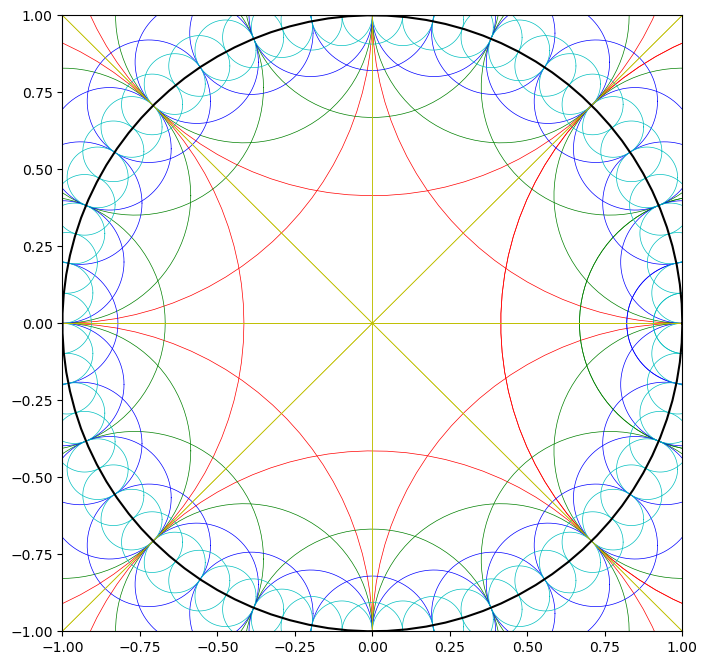

In [25]:
# Source: https://9to5tutorial.com/drawing-a-poincare-disc-in-python

import numpy as np
import matplotlib.pyplot as plt

theta = np.linspace(0,2*np.pi,100)
colorlist = ["r","g","b","c","m","y"]

fig, ax = plt.subplots(figsize=(8, 8))

t = list(range(0,6))
for n in t:
    n2 = np.power(2,n)
    for phi in np.linspace(0,2*np.pi,2*n2+1):
        x = np.cos(theta)*np.tan(np.pi/n2) + np.cos(phi)/np.cos(np.pi/n2)
        y = np.sin(theta)*np.tan(np.pi/n2) + np.sin(phi)/np.cos(np.pi/n2)
        ax.plot(x, y, lw=0.5, color=colorlist[n-2])

for phi in np.linspace(0,2*np.pi,9):
    t = np.linspace(-2,2,100)
    x = t*np.cos(phi)
    y = t*np.sin(phi)
    ax.plot(x,y,lw=0.5,color='y')

ax.plot(np.cos(theta),np.sin(theta),color='black')
ax.set(xlim=(-1,1), ylim=(-1,1))

fig.show()

In [26]:
def contains_str(lst):
    return sum([isinstance(x, str) for x in lst]) > 0


def plot(x, y, features):
    # Create the Plotly figure
    fig = go.Figure()
    
    # set figure size
    fig.update_layout(
        autosize=False, width=700, height=700
    )

    # Add scatter plot
    feature_values = list(features.values())[0]
    if contains_str(feature_values):
            feature_values = LabelEncoder().fit_transform(feature_values)
    scatter_trace = go.Scatter(
        x=x,
        y=y,
        mode='markers',
        marker=dict(
            size=10,
            color=feature_values,  # Initial color is based on first feature
            colorscale='Viridis',
            showscale=True
        )
    )
    fig.add_trace(scatter_trace)
    
    # add circle
    fig.add_shape(
        type="circle",
        xref="x", yref="y",
        x0=-1, y0=-1, x1=1, y1=1,
        line_color="black",
    )
    
    # create options for dropdown menu
    menu_options = []
    for feature_name, feature_values in features.items():
        if contains_str(feature_values):
            feature_values = LabelEncoder().fit_transform(feature_values)
        menu_options.append(
            {'label': feature_name, 'method': 'update', 'args': [{'marker.color': [feature_values]}]}
            )
    
    # create dropdown menu
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=menu_options,
                direction='down',
                pad={'r': 10, 't': 10},
                showactive=True,
                x=0.11,
                xanchor='left',
                y=1.1,
                yanchor='top'
            ),
        ]
    )
    
    # Add annotation
    fig.update_layout(
        annotations=[
            dict(text="Color by", showarrow=False,
            x=0, y=1.07, xref='paper', yref='paper', align="left")
        ]
    )

    # set limits
    offset = 0.05
    fig.update_xaxes(range=[-1 - offset, 1 + offset])
    fig.update_yaxes(range=[-1 - offset, 1 + offset])

    return fig